# Example of running level 2 processing steps

starts with 10 min RS* data to speed things up, but could use LS* and ts.decimate_1s_to_300s()

In [1]:
import numpy as np
import pandas as pd
import earthscopestraintools
import importlib
importlib.reload(earthscopestraintools)
from earthscopestraintools.tiledbtools import RawStrainWriter, RawStrainReader, ProcessedStrainWriter, ProcessedStrainReader
from earthscopestraintools.mseed_tools import ts_from_mseed
from earthscopestraintools.gtsm_metadata import GtsmMetadata
from earthscopestraintools.timeseries import Timeseries, plot_timeseries_comparison
from earthscopestraintools.processing import decimate_1s_to_300s, butterworth_filter, interpolate, linearize

import logging
logger = logging.getLogger()
logging.basicConfig(
        format="%(message)s", level=logging.INFO
    )

In [2]:
network = 'PB'
station = 'B004'
meta = GtsmMetadata(network,station)

Loading T0 RS* from 2023-01-01T00:00:00 to 2023-02-01T00:00:00 from IRIS DMC miniseed
    Trace 1. 2023-01-01T00:00:00.000000Z:2023-02-01T00:00:00.000000Z mapping RS1 to CH0
    Trace 2. 2023-01-01T00:00:00.000000Z:2023-02-01T00:00:00.000000Z mapping RS2 to CH1
    Trace 3. 2023-01-01T00:00:00.000000Z:2023-02-01T00:00:00.000000Z mapping RS3 to CH2
    Trace 4. 2023-01-01T00:00:00.000000Z:2023-02-01T00:00:00.000000Z mapping RS4 to CH3
    Found 0 epochs with nans, 0.0 epochs with 999999s, and 0 missing epochs.
    Total missing data is 0.0%
Converting missing data from 999999 to nan
    Found 0 epochs with nans, 0.0 epochs with 999999s, and 0 missing epochs.
    Total missing data is 0.0%
PB.B004.T0.RS*
    | Channels: ['CH0', 'CH1', 'CH2', 'CH3']             
    | TimeRange: 2023-01-01 00:00:00 - 2023-02-01 00:00:00        | Period:           600s
    | Series:         raw| Units:        counts| Level:          0| Gaps:             0.0% 
    | Epochs:        4465| Good:         4465.0

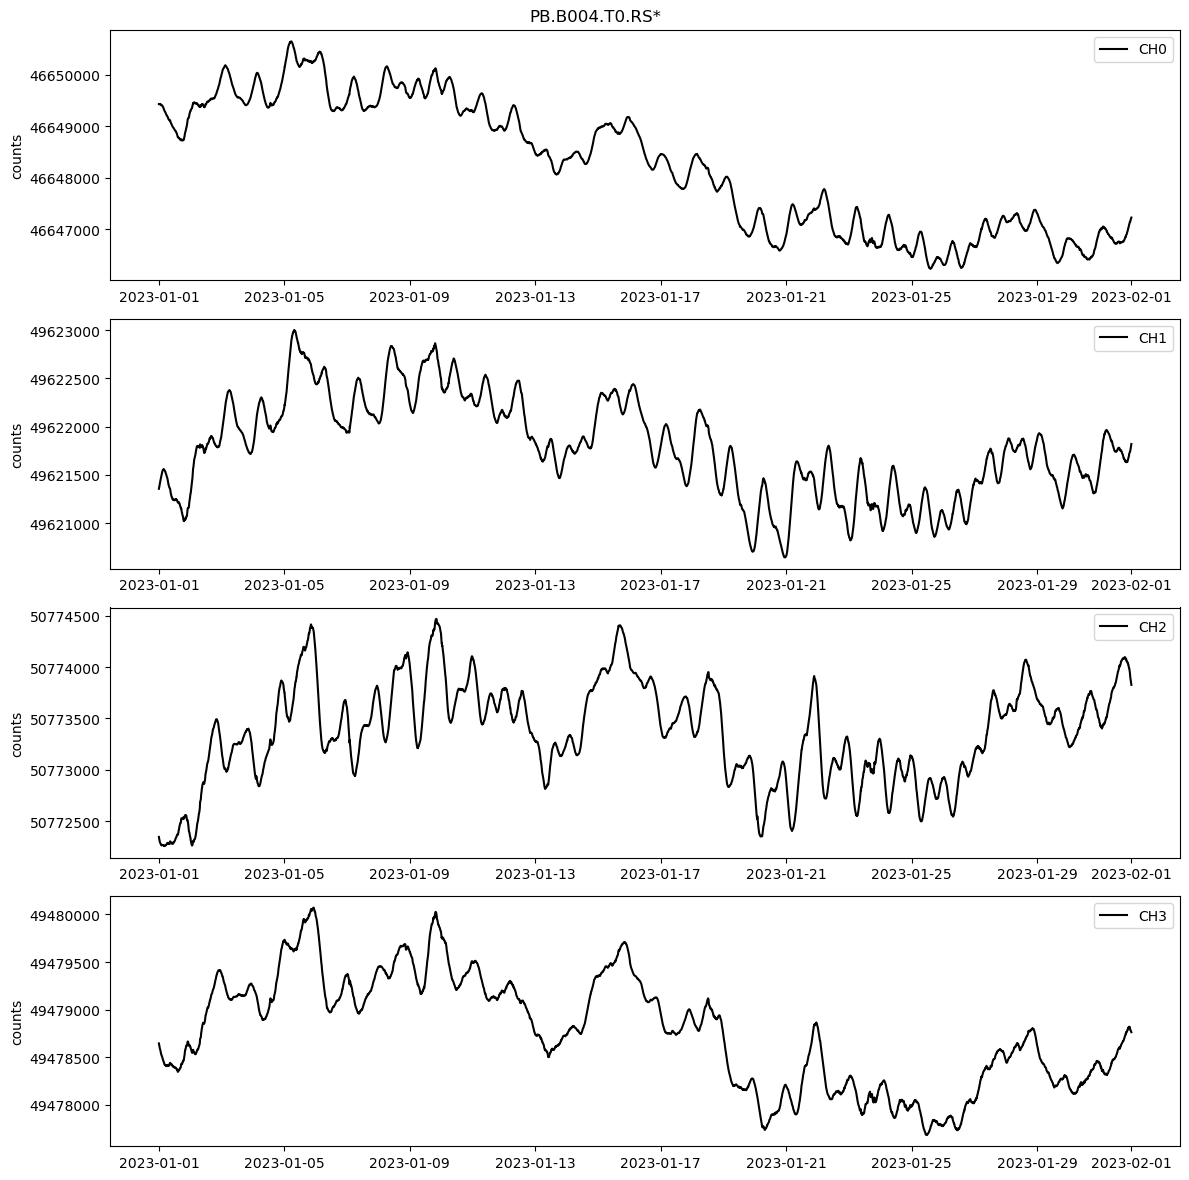

In [3]:
start="2023-01-01T00:00:00"
end = "2023-02-01T00:00:00"
strain_raw = ts_from_mseed(network=network, station=station, location='T0', channel='RS*', start=start, end=end)
strain_raw.stats()
strain_raw.plot(type='line')

Converting raw counts to microstrain
    Found 0 epochs with nans, 0.0 epochs with 999999s, and 0 missing epochs.
    Total missing data is 0.0%
PB.B004.gauge.microstrain
    | Channels: ['CH0', 'CH1', 'CH2', 'CH3']             
    | TimeRange: 2023-01-01 00:00:00 - 2023-02-01 00:00:00        | Period:           600s
    | Series: microstrain| Units:   microstrain| Level:          1| Gaps:             0.0% 
    | Epochs:        4465| Good:         4465.0| Missing:      0.0| Interpolated:      0.0
    | Samples:      17860| Good:          17860| Missing:        0| Interpolated:        0


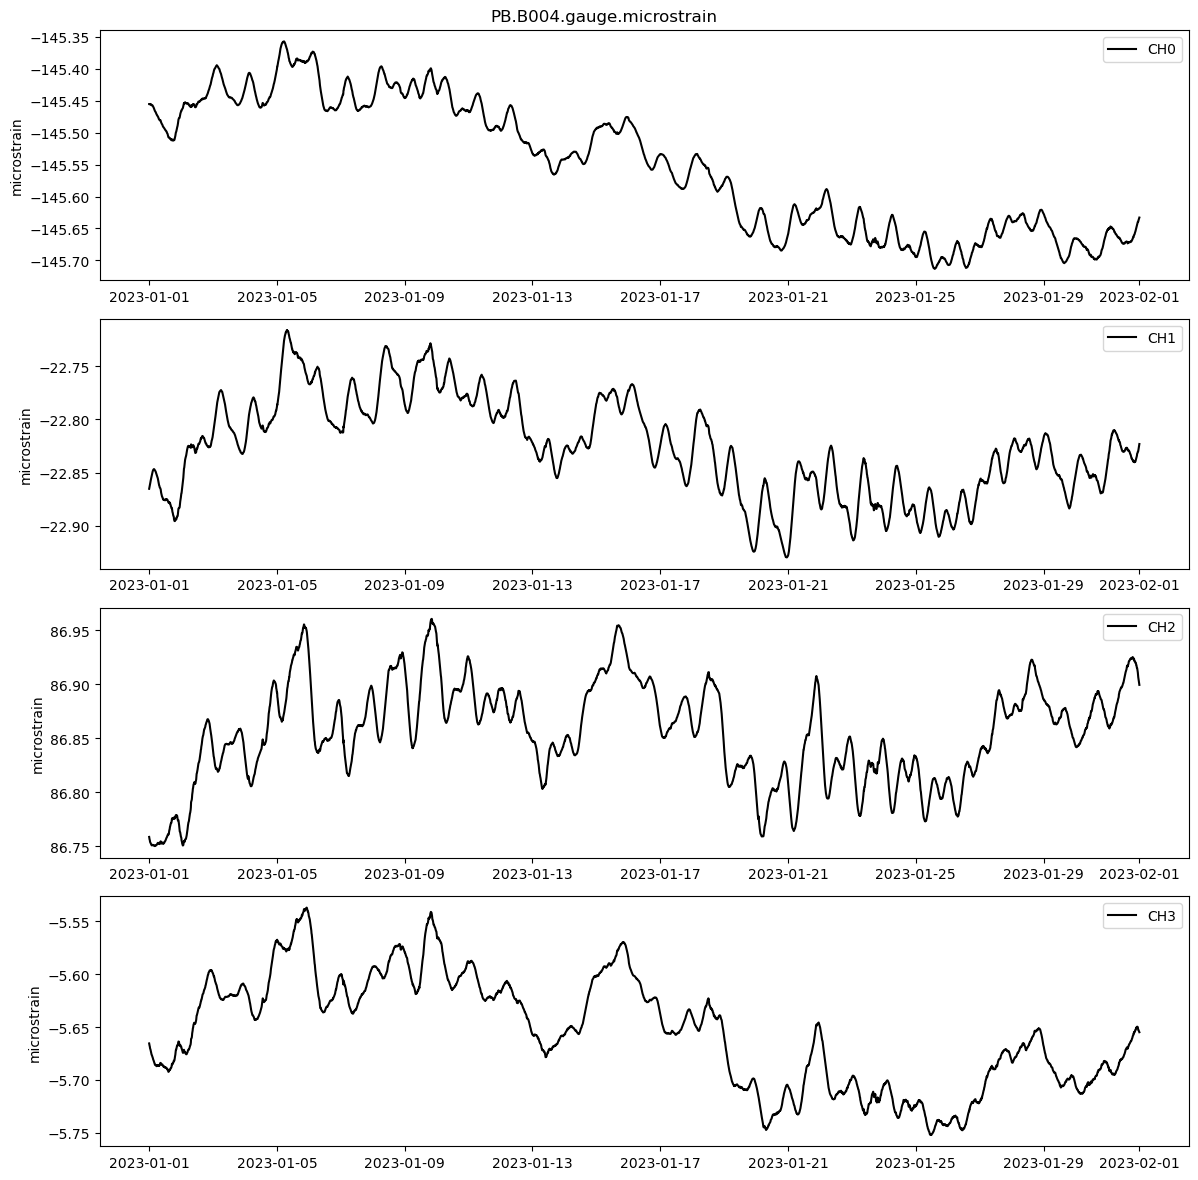

In [4]:
name = f"{network}.{station}.gauge.microstrain"
gauge_microstrain = strain_raw.linearize(reference_strains=meta.reference_strains, gap=meta.gap, name=name)
gauge_microstrain.stats()
gauge_microstrain.plot()

### Calibration

In [5]:
# regional_microstrain = gauge_microstrain.apply_calibration_matrix(meta.strain_matrices['lab_strain_matrix'])
# regional_microstrain.stats()
# regional_microstrain.quality_stats()
# regional_microstrain.plot()

### Trend

Calculating linear trend correction
    Trend Start: 2023-01-01 00:00:00
    Trend Start: 2023-02-01 00:00:00
    Found 0 epochs with nans, 0.0 epochs with 999999s, and 0 missing epochs.
    Total missing data is 0.0%
Applying corrections
    Found 0 epochs with nans, 0.0 epochs with 999999s, and 0 missing epochs.
    Total missing data is 0.0%


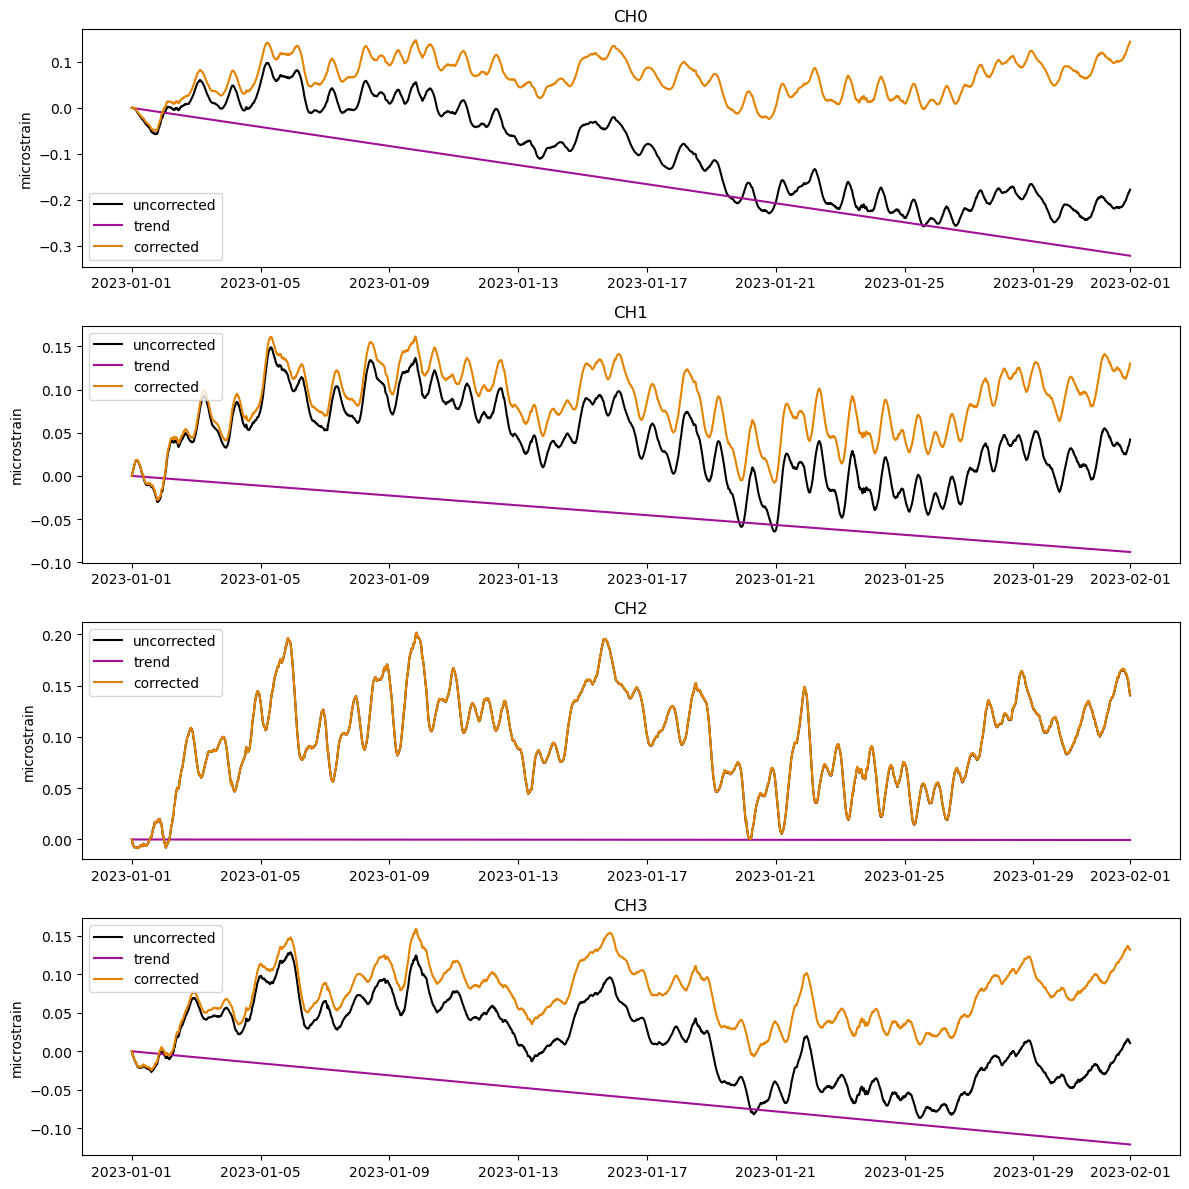

In [6]:
name = f"{network}.{station}.gauge.trend_c"
trend_c = gauge_microstrain.linear_trend_correction(name=name)
#trend_c.plot()
corrected = gauge_microstrain.apply_corrections([trend_c])
plot_timeseries_comparison([gauge_microstrain, trend_c, corrected], names=['uncorrected', 'trend', 'corrected'], zero=True)

### Tides

Calculating tide correction
    Found 0 epochs with nans, 0.0 epochs with 999999s, and 0 missing epochs.
    Total missing data is 0.0%


/opt/spotl/bin/hartid


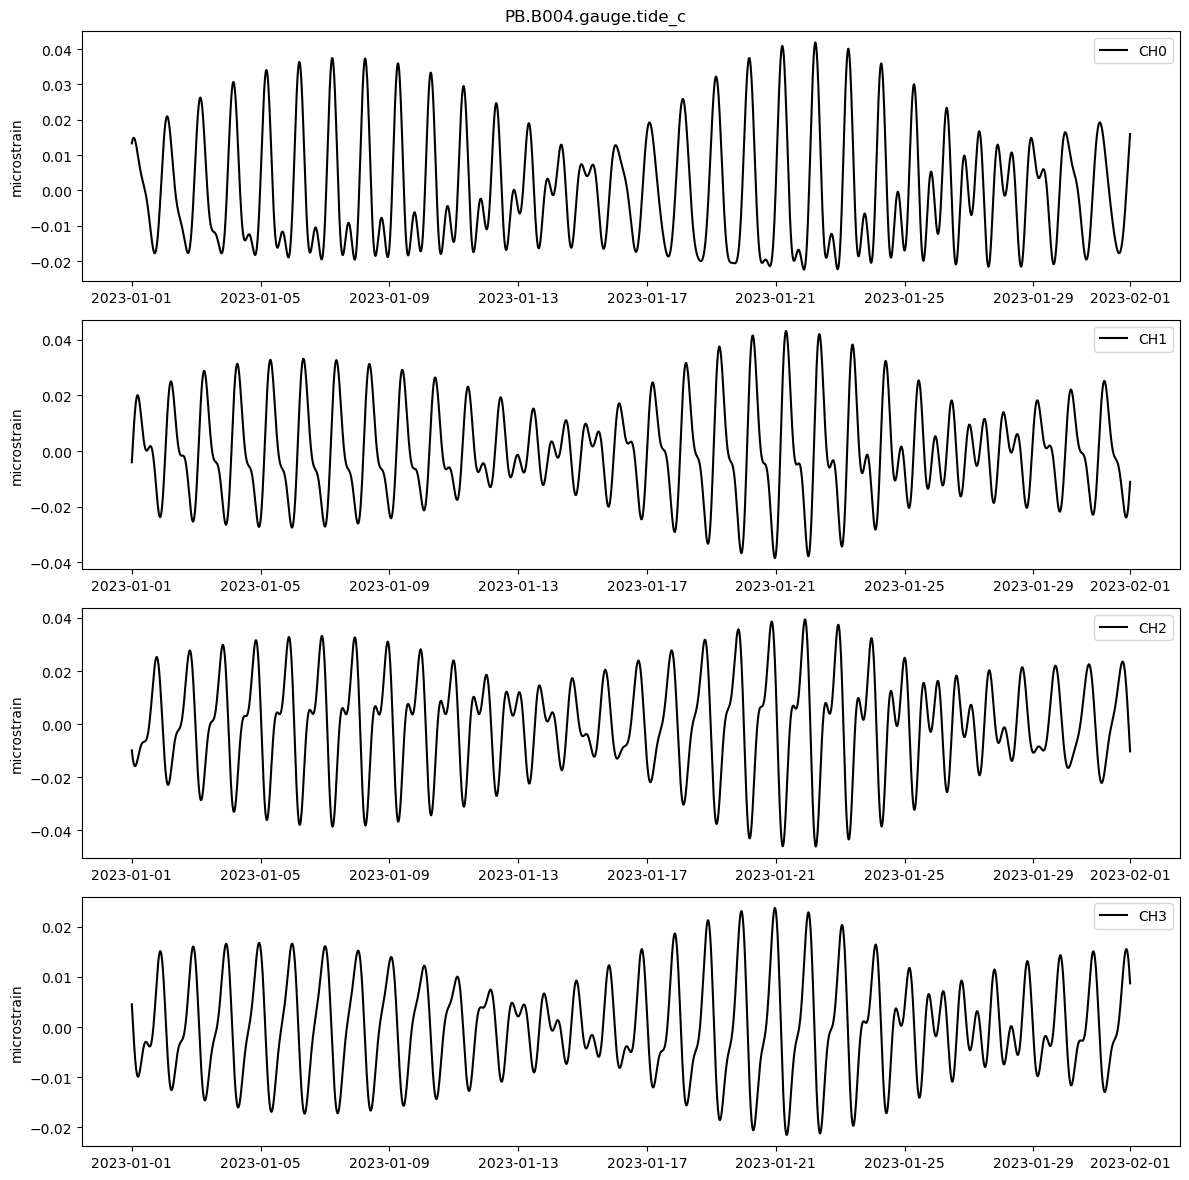

In [7]:
name = f"{network}.{station}.gauge.tide_c"
tide_c = gauge_microstrain.calculate_tide_correction(tidal_parameters=meta.tidal_params, longitude=meta.longitude, name=name)
tide_c.plot()
#tide_corrected = gauge_microstrain.apply_corrections([tide_c])
#plot_timeseries_comparison([gauge_microstrain, tide_corrected], names=['uncorrected', 'atmp_corrected'], zero=True)

### Pressure

Loading * RDO from 2023-01-01T00:00:00 to 2023-02-01T00:00:00 from IRIS DMC miniseed
    Trace 1. 2023-01-01T00:00:00.000000Z:2023-02-01T00:00:00.000000Z mapping RDO to atmp
    Found 0 epochs with nans, 0.0 epochs with 999999s, and 0 missing epochs.
    Total missing data is 0.0%
Converting missing data from 999999 to nan
    Found 0 epochs with nans, 0.0 epochs with 999999s, and 0 missing epochs.
    Total missing data is 0.0%
Interpolating data using method=linear and limit=6
    Found 0 epochs with nans, 0.0 epochs with 999999s, and 0 missing epochs.
    Total missing data is 0.0%
Calculating pressure correction
    Found 0 epochs with nans, 0.0 epochs with 999999s, and 0 missing epochs.
    Total missing data is 0.0%


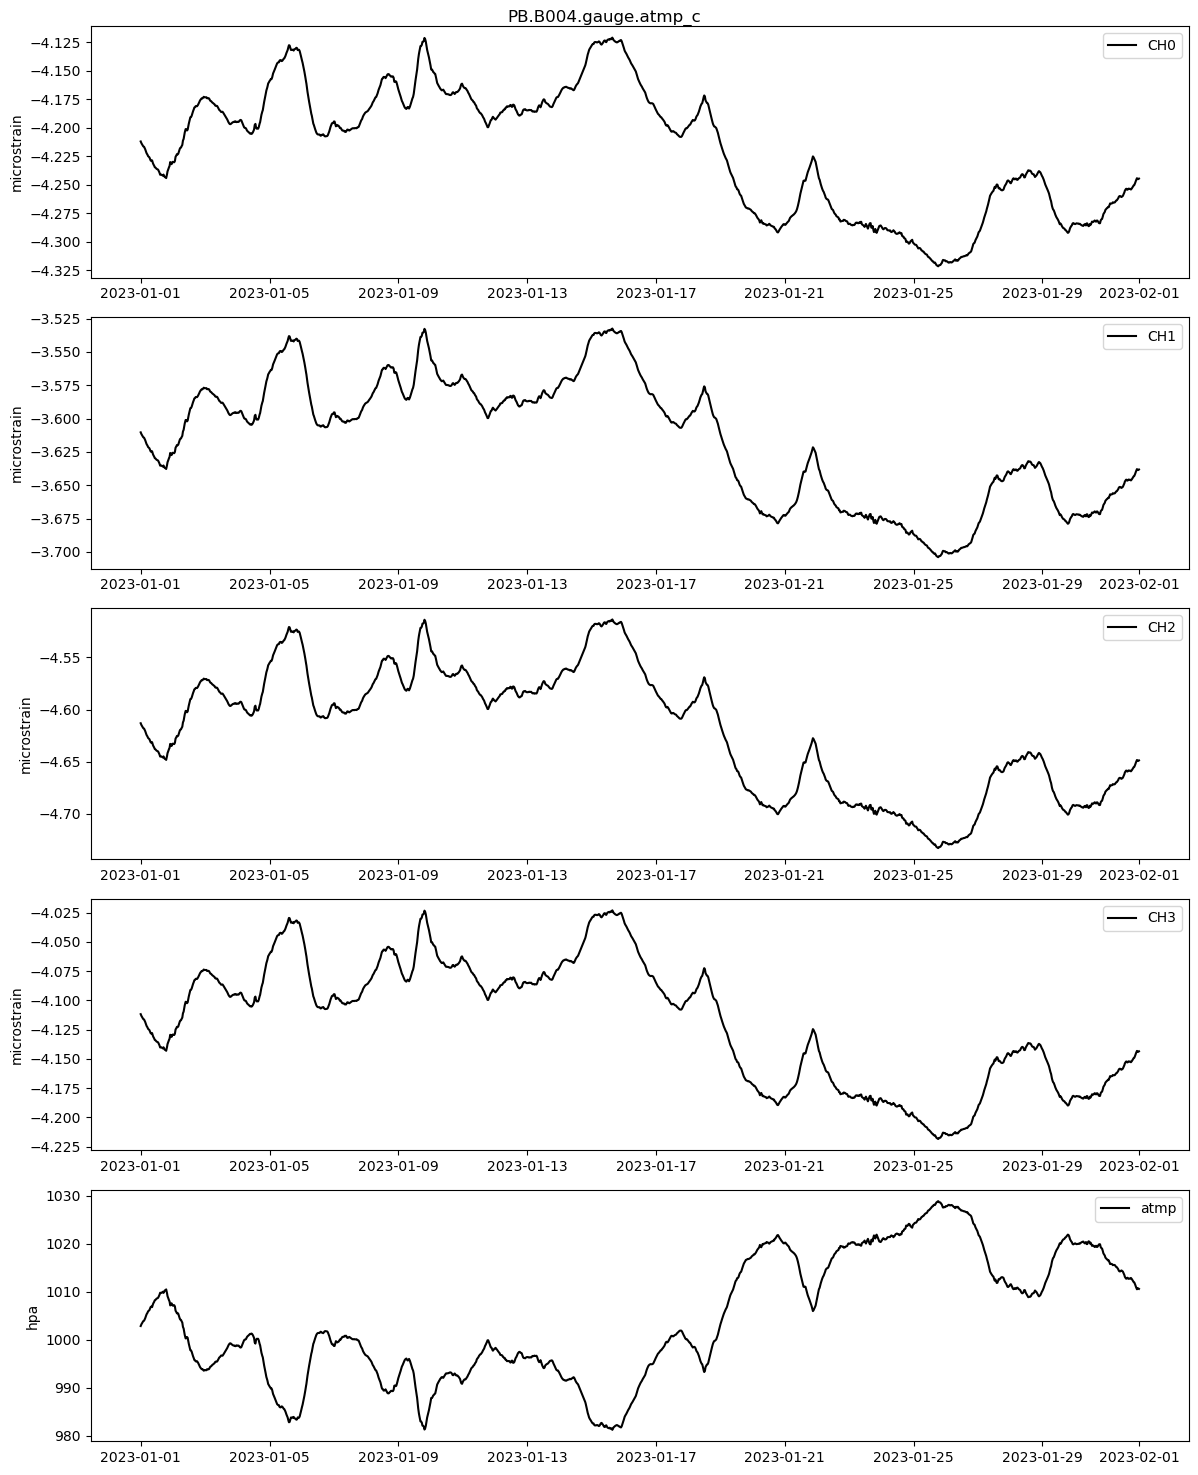

In [8]:
atmp_raw = ts_from_mseed(network=network, station=station, location='*', channel='RDO', 
                        start=start, end=end, period=60*30, scale_factor=0.001, units='hpa')
# atmp_raw.stats()
# atmp_raw.quality_stats()
# atmp_raw.plot()
atmp = atmp_raw.interpolate(new_index=strain_raw.data.index, series='hpa')
# atmp.stats()
# atmp.quality_stats()
# atmp.plot()

name = f"{network}.{station}.gauge.atmp_c"
atmp_c = atmp.calculate_pressure_correction(meta.atmp_response, name=name)
atmp_c.plot(atmp=atmp)
#atmp_corrected = gauge_microstrain.apply_corrections([atmp_c])
#atmp_corrected.plot()
#plot_timeseries_comparison([gauge_microstrain, atmp_corrected], names=['uncorrected', 'atmp_corrected'], zero=True)



### Offsets

Calculating offsets using cutoff percentile of 0.75 and limit multiplier of 10.
Using offset limits of [0.006652, 0.006331, 0.007588, 0.004766]
    Found 0 epochs with nans, 0.0 epochs with 999999s, and 0 missing epochs.
    Total missing data is 0.0%


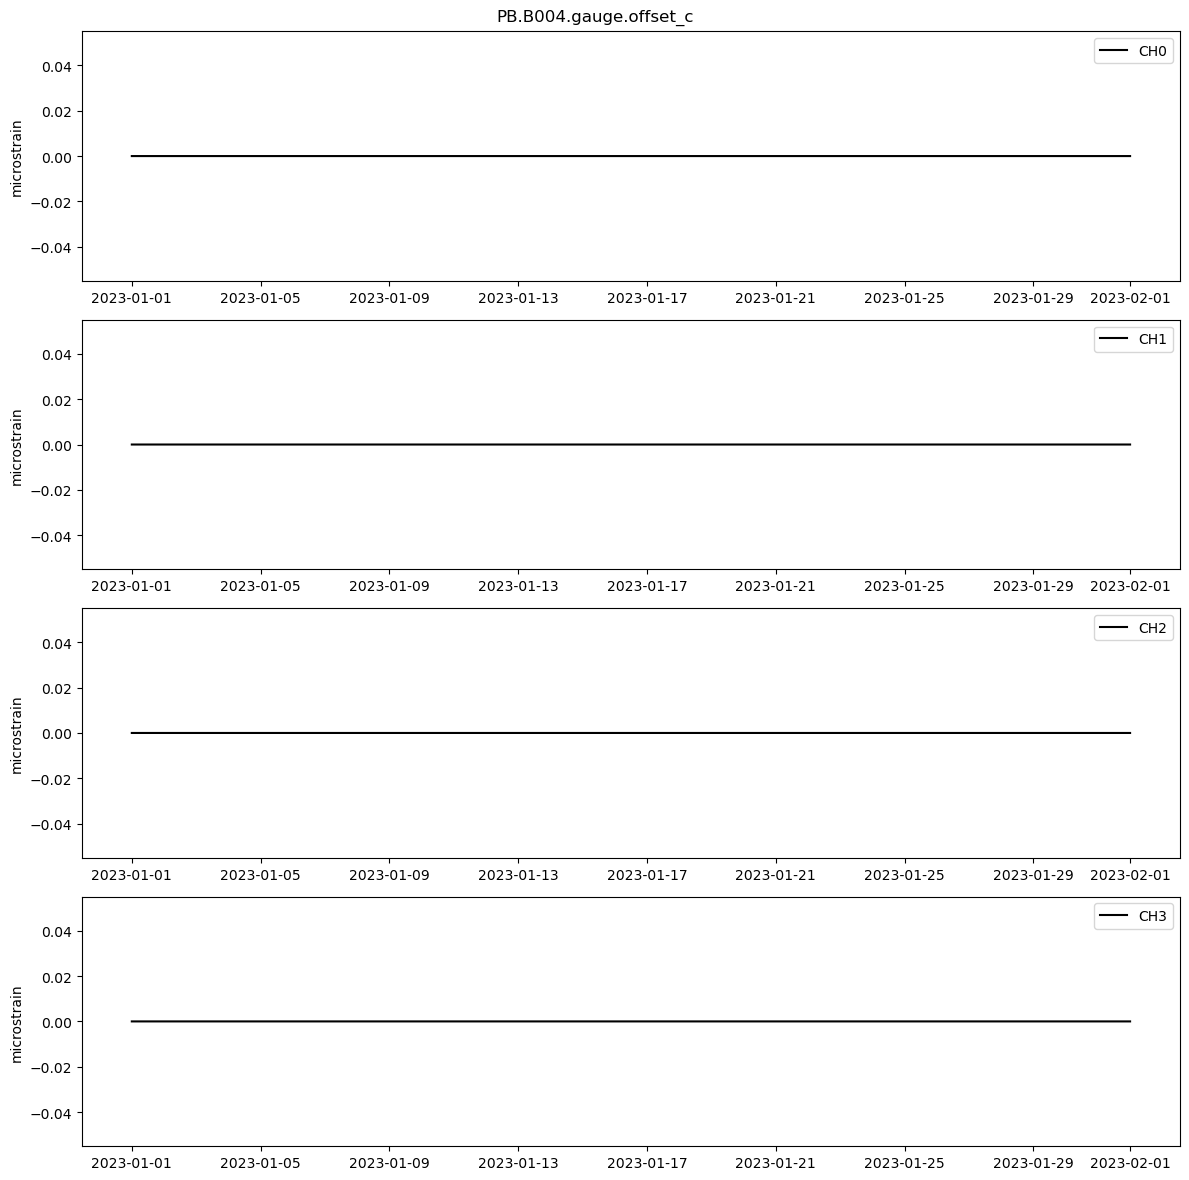

In [9]:
name = f"{network}.{station}.gauge.offset_c"
offset_c = gauge_microstrain.calculate_offsets(name=name)
offset_c.plot()

### Plot corrections

Applying corrections
    Found 0 epochs with nans, 0.0 epochs with 999999s, and 0 missing epochs.
    Total missing data is 0.0%


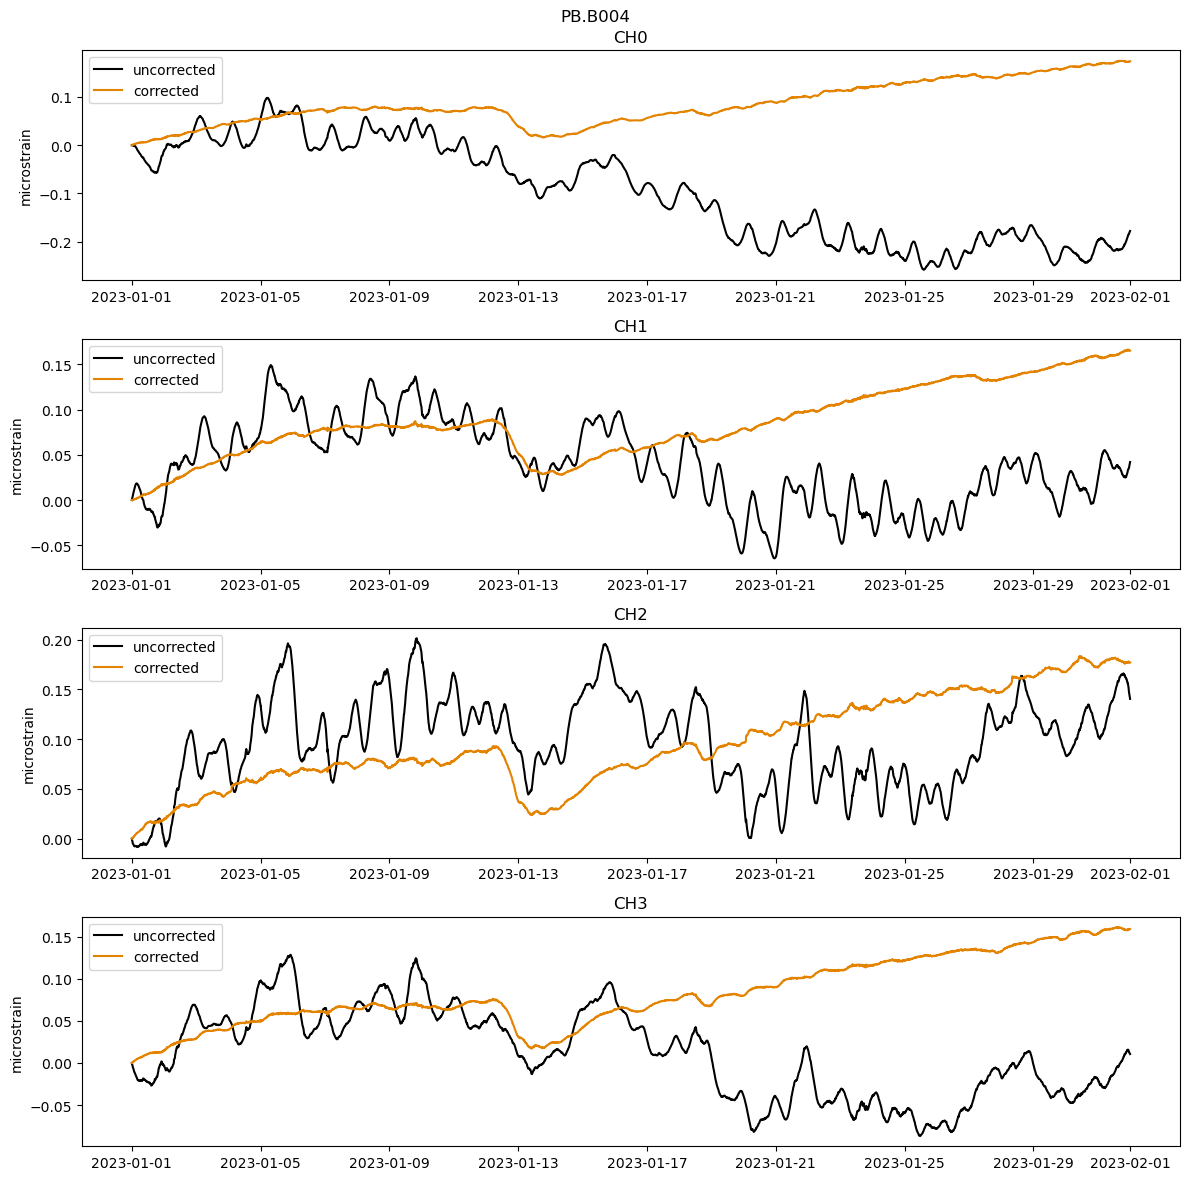

In [10]:
title=f"{network}.{station}"
corrected = gauge_microstrain.apply_corrections([tide_c, atmp_c, offset_c, trend_c])
plot_timeseries_comparison([gauge_microstrain, corrected], title=title, names=['uncorrected', 'corrected'], zero=True)

### Rainfall

Loading * RRO from 2023-01-01T00:00:00 to 2023-02-01T00:00:00 from IRIS DMC miniseed
    Trace 1. 2023-01-01T00:00:00.000000Z:2023-02-01T00:00:00.000000Z mapping RRO to rain
    Found 0 epochs with nans, 0.0 epochs with 999999s, and 0 missing epochs.
    Total missing data is 0.0%
Converting missing data from 999999 to nan
    Found 0 epochs with nans, 0.0 epochs with 999999s, and 0 missing epochs.
    Total missing data is 0.0%
PB.B004.gauge.microstrain.corrected
    | Channels: ['CH0', 'CH1', 'CH2', 'CH3']             
    | TimeRange: 2023-01-01 00:00:00 - 2023-02-01 00:00:00        | Period:           600s
    | Series:   corrected| Units:   microstrain| Level:         2a| Gaps:             0.0% 
    | Epochs:        4465| Good:         4465.0| Missing:      0.0| Interpolated:      0.0
    | Samples:      17860| Good:          17860| Missing:        0| Interpolated:        0


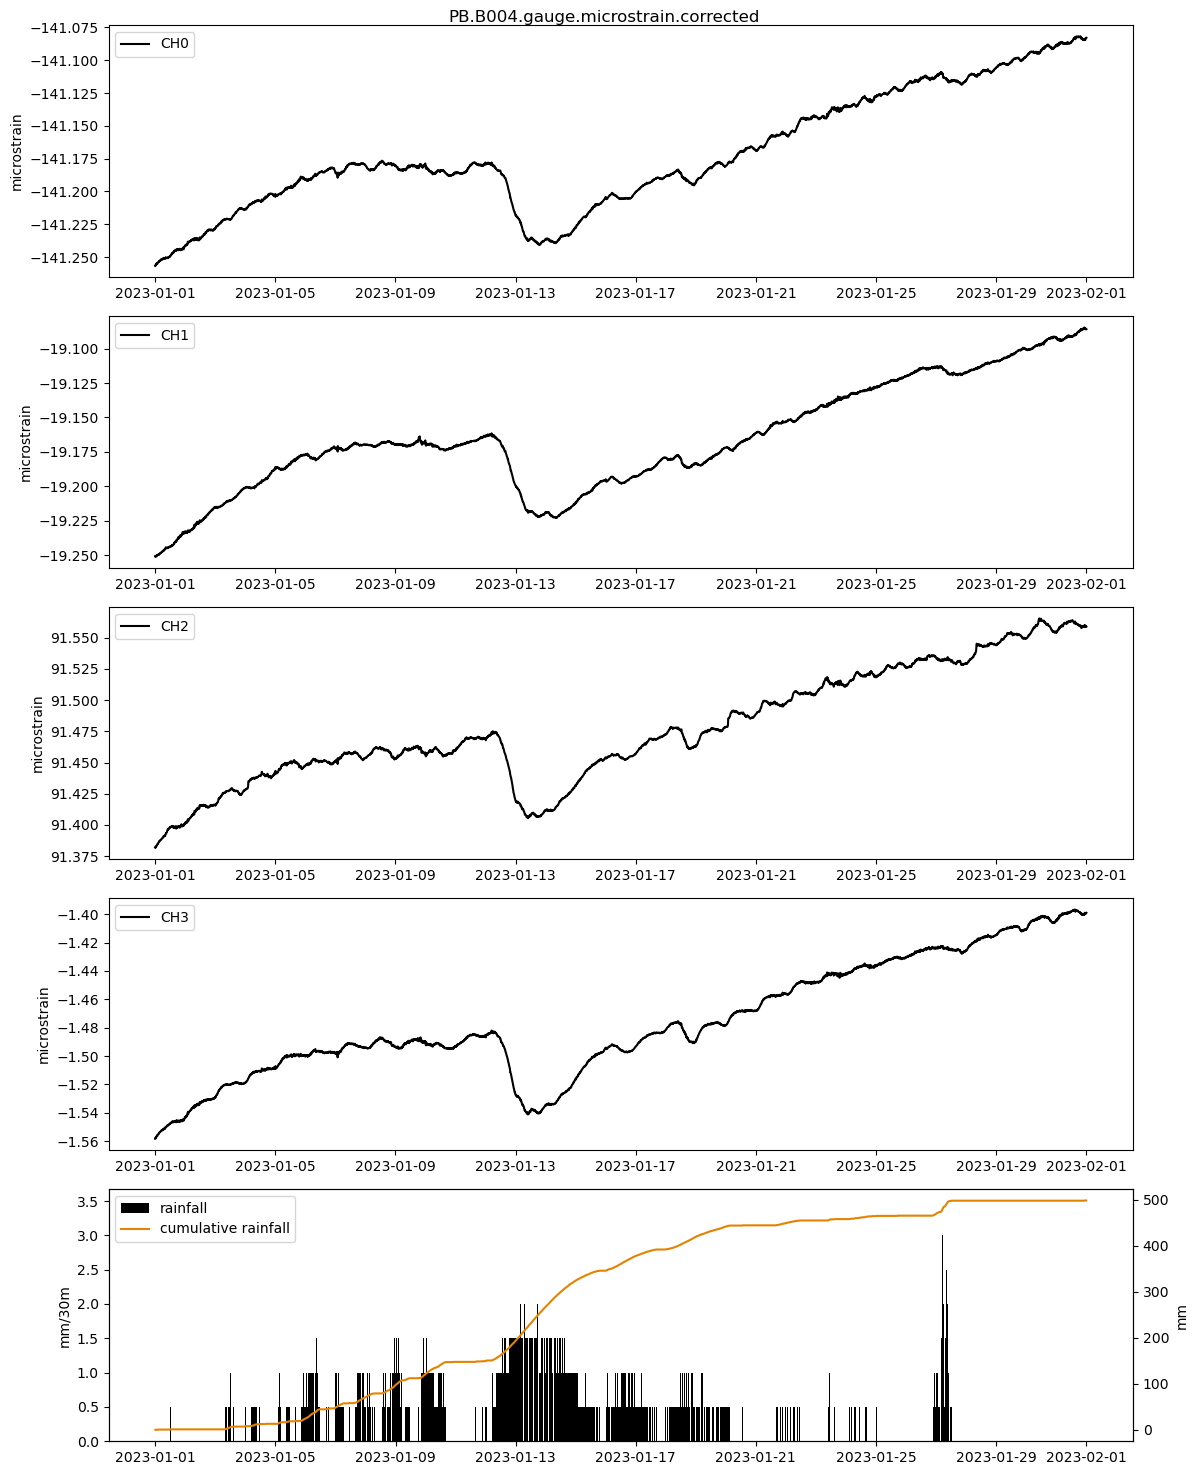

In [11]:
rainfall = ts_from_mseed(network=network, station=station, location='*', channel='RRO', 
                         start=start, end=end, period=60*30, scale_factor=0.0001, units='mm/30m')
corrected.plot(rainfall=rainfall)
corrected.stats()